In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
from psireact import model
import psireact.plot
import garnet.rt

data_file = '/Users/morton/Dropbox/data/garnet/garnet_alldata_04302020.csv'
res_dir = '/Users/morton/Dropbox/work/garnet'

### Get high similarity AC trials

In [2]:
raw = garnet.rt.read_data(data_file)
data = raw.loc[raw['rt'].notna()].copy()
data = data.loc[data['test'] == 'AC']
high = data.loc[data['similarity'] == 2].copy()

In [3]:
high

,subject,phase,run,triad,similarity,accuracy,rt,react_run,react_avg,ca1,ca3,sub,subj_idx,test,response,split
136,1,2,1,2,2,1,6.95647,NaN,-0.02643,NaN,-0.08782,-0.16475,0,AC,1,1
137,1,2,1,6,2,1,2.96086,NaN,0.00425,NaN,-0.03966,0.13465,0,AC,1,1
138,1,2,1,10,2,0,3.95413,NaN,0.02715,NaN,0.09827,-0.20324,0,AC,0,2
139,1,2,1,14,2,1,7.25281,NaN,-0.00023,NaN,0.13853,-0.12119,0,AC,1,1
140,1,2,1,18,2,0,7.63901,NaN,0.07189,NaN,-0.02613,-0.17788,0,AC,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4139,26,2,1,14,2,1,2.75859,NaN,0.08083,0.19827,-0.04990,-0.05051,25,AC,1,2
4140,26,2,1,18,2,1,3.31936,NaN,0.03099,-0.06580,-0.10913,-0.23866,25,AC,1,2
4141,26,2,1,22,2,0,2.88047,NaN,-0.02793,0.20795,0.05420,0.20915,25,AC,0,1
4142,26,2,1,26,2,1,2.65057,NaN,0.05707,0.04029,-0.01862,-0.22546,25,AC,1,2


### Across-subject z-score of integration

In [4]:
rois = ['ca1', 'ca3', 'sub', 'react_avg']
m = high.groupby('subj_idx')[rois].mean()
for roi in rois:
    f = f'z_{roi}'
    zstat = (m[roi] - m[roi].mean()) / m[roi].std()
    m[f] = zstat

### Within-subject z-score of integration

In [5]:
sd = high.groupby('subj_idx')[rois].std()
for roi in rois:
    f = f'z_{roi}'
    high[f] = 0
    for subject in high['subj_idx'].unique():
        include = high['subj_idx'] == subject
        zstat = (high.loc[include, roi] - m.loc[subject, roi]) / sd.loc[subject, roi]
        high.loc[include, f] = zstat
for subject in high['subj_idx'].unique():
    include = high['subj_idx'] == subject
    x = high.loc[include, 'rt']
    high.loc[include, 'z_rt'] = (x - x.mean()) / x.std()

In [6]:
full_subjects = high.loc[high['ca1'].notna(), 'subj_idx']
m_final = m.loc[m.index.isin(full_subjects)]
final = high.loc[high['subj_idx'].isin(full_subjects)]

In [7]:
print(len(full_subjects.unique()))
print(len(high['subj_idx'].unique()))

25
26


In [8]:
orig_subj = final.subj_idx.to_numpy()
reindex_subj = np.zeros(orig_subj.shape, dtype=int)
for i, subject in enumerate(np.unique(orig_subj)):
    reindex_subj[orig_subj == subject] = i

## Predict trial differences using integration

In [9]:
subj_idx = reindex_subj
ca1 = final['z_ca1'].to_numpy()
ca3 = final['z_ca3'].to_numpy()
sub = final['z_sub'].to_numpy()
rct = final['z_react_avg'].to_numpy()
n_trial = final.shape[0]
n_subj = len(np.unique(subj_idx))
rt_data = {
    'rt': final['rt'].to_numpy(),
    'response': final['response'].to_numpy(),
    'test': final['phase'].to_numpy()
}
with pm.Model() as graph:
    v1_int = pm.Normal('v1_int', mu=0, sd=4, shape=n_subj)

    v2_mu = pm.Normal('v2_mu', sd=4)
    v2_sd = pm.Gamma('v2_sd', alpha=1.5, beta=0.75)
    v2_offset = pm.Normal('v2_offset', mu=0, sd=1, shape=n_subj)
    v2 = pm.Deterministic('v2', v2_mu + v2_sd * v2_offset)
    
    B_ca1_mu = pm.Normal('B_ca1_mu', sd=4)
    B_ca1_sd = pm.Gamma('B_ca1_sd', alpha=1.5, beta=0.75)
    B_ca1_offset = pm.Normal('B_ca1_offset', mu=0, sd=1, shape=n_subj)
    B_ca1 = pm.Deterministic('B_ca1', B_ca1_mu + B_ca1_sd * B_ca1_offset)
    
    B_ca3_mu = pm.Normal('B_ca3_mu', sd=4)
    B_ca3_sd = pm.Gamma('B_ca3_sd', alpha=1.5, beta=0.75)
    B_ca3_offset = pm.Normal('B_ca3_offset', mu=0, sd=1, shape=n_subj)
    B_ca3 = pm.Deterministic('B_ca3', B_ca3_mu + B_ca3_sd * B_ca3_offset)
    
    B_sub_mu = pm.Normal('B_sub_mu', sd=4)
    B_sub_sd = pm.Gamma('B_sub_sd', alpha=1.5, beta=0.75)
    B_sub_offset = pm.Normal('B_sub_offset', mu=0, sd=1, shape=n_subj)
    B_sub = pm.Deterministic('B_sub', B_sub_mu + B_sub_sd * B_sub_offset)
    
    B_rct_mu = pm.Normal('B_rct_mu', sd=4)
    B_rct_sd = pm.Gamma('B_rct_sd', alpha=1.5, beta=0.75)
    B_rct_offset = pm.Normal('B_rct_offset', mu=0, sd=1, shape=n_subj)
    B_rct = pm.Deterministic('B_rct', B_rct_mu + B_rct_sd * B_rct_offset)
    
    v1 = pm.Deterministic(
        'v1', v1_int[subj_idx] +
        B_ca1[subj_idx] * ca1 +
        B_ca3[subj_idx] * ca3 +
        B_sub[subj_idx] * sub +
        B_rct[subj_idx] * rct
    )

    s = 1
    b = 8
    
    A = pm.Uniform('A', lower=0, upper=b)
    tau = pm.Uniform('tau', lower=0, upper=2)
    
    def logp(rt, response, test):
        p = garnet.rt.tpdf31(rt - tau, response, test, A, b, v1, v2[subj_idx], s)
        return psireact.model.log_prob(p)

    response = pm.DensityDist('response', logp, observed=rt_data)

In [10]:
trace_trial = pm.sample(tune=1000, draws=5000, model=graph, target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, A, B_rct_offset, B_rct_sd, B_rct_mu, B_sub_offset, B_sub_sd, B_sub_mu, B_ca3_offset, B_ca3_sd, B_ca3_mu, B_ca1_offset, B_ca1_sd, B_ca1_mu, v2_offset, v2_sd, v2_mu, v1_int]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 266 seconds.


/Users/morton/miniconda3/envs/garnet/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/morton/miniconda3/envs/garnet/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  UserWarning,


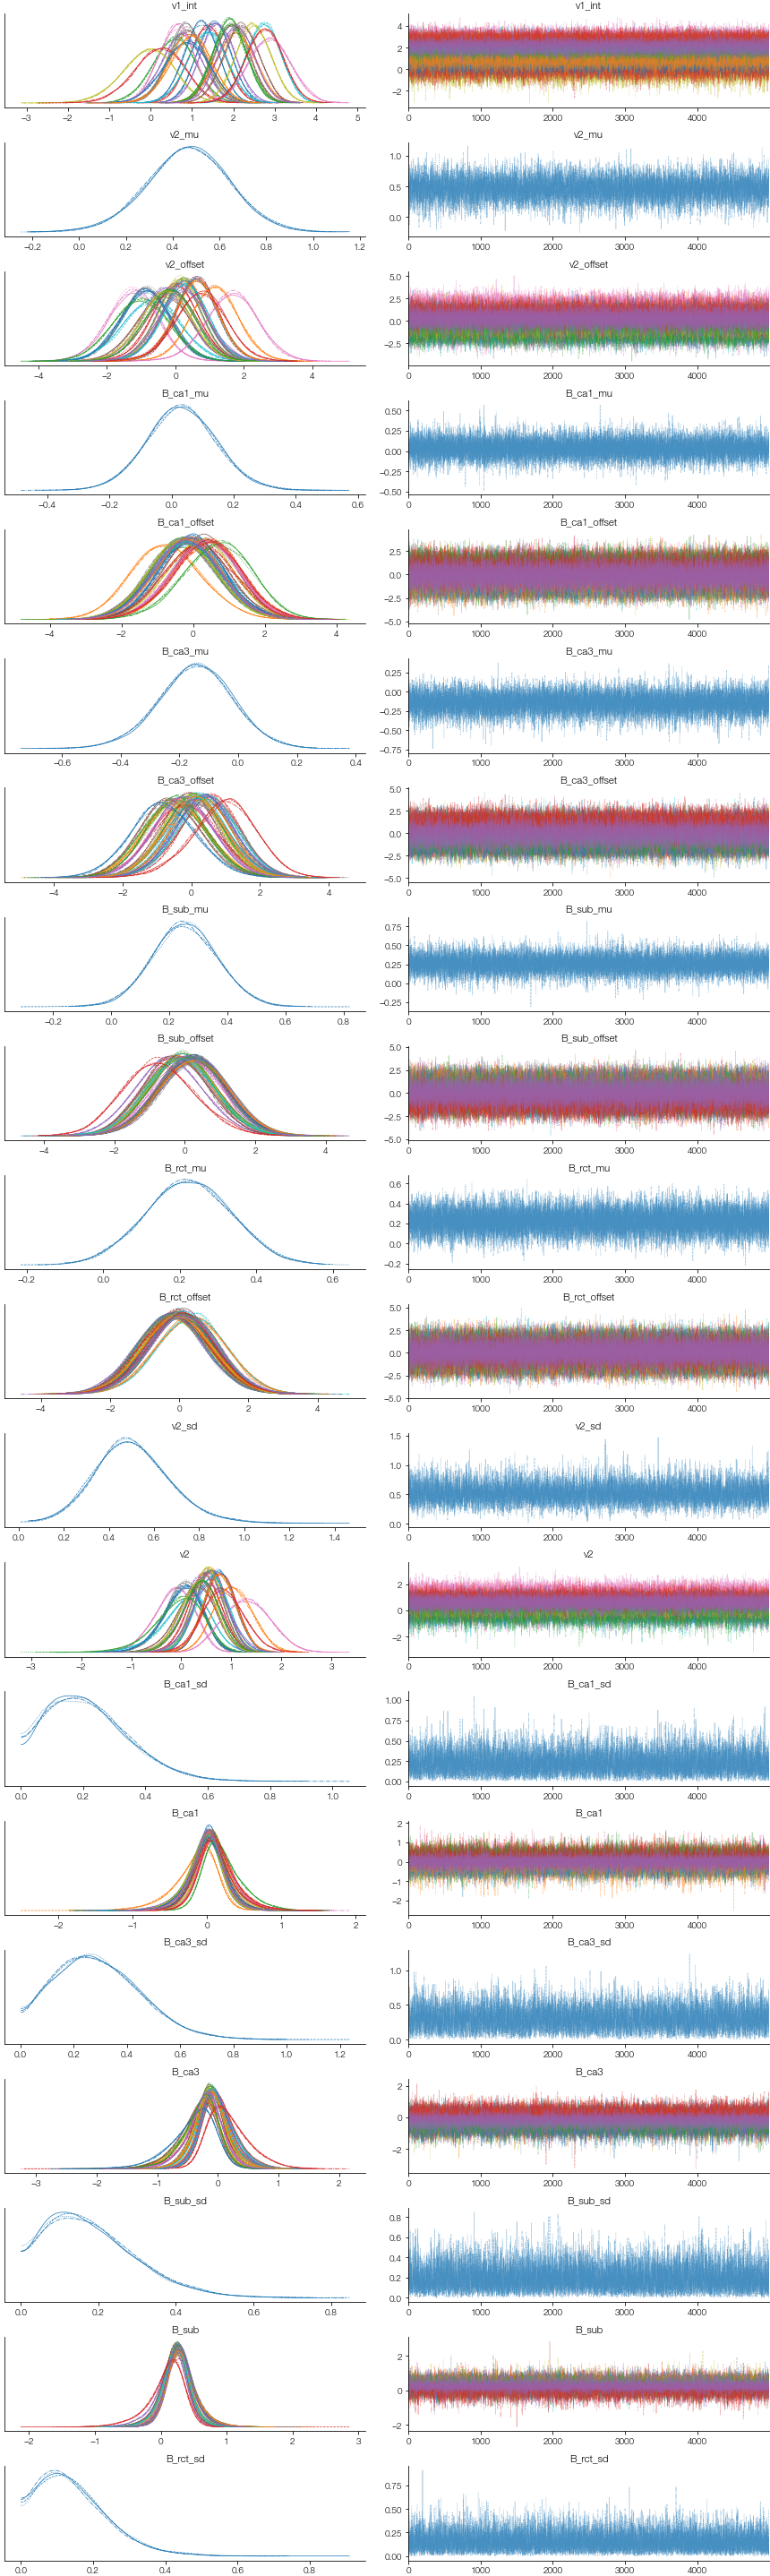

In [11]:
pm.traceplot(trace_trial);

/Users/morton/miniconda3/envs/garnet/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


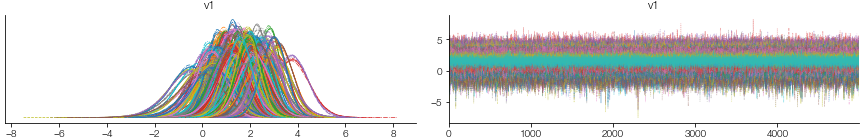

In [26]:
pm.traceplot(trace_trial, var_names=['v1']);

In [12]:
with graph:
    out = pm.save_trace(trace_trial, os.path.join(res_dir, 'trace_trial_hier'), overwrite=True)

    ess = pm.stats.ess(trace_trial)
    ess.to_netcdf(os.path.join(res_dir, 'trace_trial_hier_ess.nc'))

    rhat = pm.rhat(trace_trial)
    rhat.to_netcdf(os.path.join(res_dir, 'trace_trial_hier_rhat.nc'))

In [13]:
df_rhat = garnet.rt.summarize_trace_stats(rhat)
print(f"max rhat: {df_rhat['max'].max()}")

df_ess = garnet.rt.summarize_trace_stats(ess)
print(f"min ess: {df_ess['min'].min()}")

max rhat: 1.0010178061582646
min ess: 5225.0430169081865


In [ ]:
with graph:
    ds = az.convert_to_dataset(trace_trial)

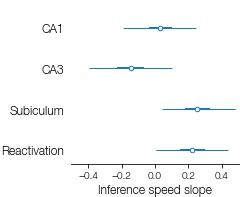

In [25]:
fig, ax = plt.subplots(figsize=(3, 3))
az.plot_forest(
    ds, var_names=['B_ca1_mu', 'B_ca3_mu', 'B_sub_mu', 'B_rct_mu'],
    combined=True, hdi_prob=0.95, ax=ax
);
ax.set_title('');
ax.set_xlabel('Inference speed slope', fontsize='large');
ax.set_yticklabels(['Reactivation', 'Subiculum', 'CA3', 'CA1']);
ax.set(xlim=(-.5, .5))
ax.tick_params(axis='x', labelsize='medium')
ax.tick_params(axis='y', labelsize='large')
fig.savefig(os.path.join(res_dir, 'slope_forest.pdf'))

In [16]:
slopes = ['B_ca1_mu', 'B_ca3_mu', 'B_sub_mu', 'B_rct_mu']
for slope in slopes:
    print(slope, az.hdi(trace_trial[slope], hdi_prob=.95))

B_ca1_mu [-0.18890012  0.244318  ]
B_ca3_mu [-0.39303719  0.10157657]
B_sub_mu [0.04310113 0.47730355]
B_rct_mu [0.00533443 0.43725576]


In [17]:
other_vars = [
    'A', 'tau', 'v2_mu', 'v2_sd', 'B_ca1_sd', 'B_ca3_sd', 'B_sub_sd', 'B_rct_sd'
]
for var in other_vars:
    print(var, az.hdi(trace_trial[var], hdi_prob=.95))

A [2.05894729 5.60059865]
tau [8.97502582e-05 5.14568269e-01]
v2_mu [0.12975467 0.81245514]
v2_sd [0.19095094 0.83127884]
B_ca1_sd [0.00363031 0.45756132]
B_ca3_sd [0.00997048 0.57666781]
B_sub_sd [0.00185642 0.40767151]
B_rct_sd [1.62849076e-04 3.27428392e-01]


## Generate simulated data

In [19]:
var_names = ['A', 'v1', 'v2', 'tau']
param = {'b': 8, 's': 1}
for var in var_names:
    param[var] = np.mean(trace_trial[var], 0)

In [20]:
n_rep = 50
n_samp = n_rep * n_trial
subj_idx = np.zeros(n_samp, dtype=int)
rt = np.zeros(n_samp)
response = np.zeros(n_samp, dtype=int)
rep = np.zeros(n_samp, dtype=int)
trial = np.zeros(n_samp, dtype=int)
n = 0
for i in range(n_rep):
    for j in range(n_trial):
        subj_idx[n] = reindex_subj[j]
        trial[n] = j
        rt[n], response[n] = garnet.rt.tpdf31_rvs(
            1, param['A'], param['b'], param['v1'][j], param['v2'][reindex_subj[j]], 
            param['s'], param['tau']
        )
        rep[n] = i
        n += 1

sim = pd.DataFrame(
    {
        'subj_idx': subj_idx, 'rt_sim': rt, 'response_sim': response,
        'rep': rep, 'trial': trial
    }
)
sim_trial = sim.loc[sim['rt_sim'] < 10].groupby('trial').mean()

In [27]:
sim_trial.head()

,subj_idx,rt_sim,response_sim,rep
trial,,,,
0,0.0,4.038342,0.738095,24.595238
1,0.0,4.890881,0.619048,24.476190
2,0.0,4.010458,0.891304,24.913043
3,0.0,3.120475,0.913043,24.891304
4,0.0,3.886880,0.804348,25.804348


In [21]:
full = sim_trial.copy()
full['rt_data'] = final['rt'].to_numpy()
full['response_data'] = final['response'].to_numpy()
for roi in rois:
    full['z_' + roi] = final['z_' + roi].to_numpy()
full['z_rt_data'] = final['z_rt'].to_numpy()
full

,subj_idx,rt_sim,response_sim,rep,rt_data,response_data,z_ca1,z_ca3,z_sub,z_react_avg,z_rt_data
trial,,,,,,,,,,,
0,0.0,4.038342,0.738095,24.595238,6.98905,1,0.894829,-1.421908,-0.532294,-1.046302,0.989926
1,0.0,4.890881,0.619048,24.476190,3.29811,1,-0.563872,-0.914384,-1.667076,-1.126805,-0.601512
2,0.0,4.010458,0.891304,24.913043,4.56982,1,0.285186,0.729882,0.372867,0.043599,-0.053183
3,0.0,3.120475,0.913043,24.891304,2.19141,1,1.657497,-0.028872,0.179340,1.510191,-1.078692
4,0.0,3.886880,0.804348,25.804348,2.68365,1,-1.139984,1.853393,1.589167,-0.415986,-0.866451
...,...,...,...,...,...,...,...,...,...,...,...
195,24.0,2.931925,0.770833,24.520833,2.75859,1,1.368724,-0.507701,-0.237454,1.120503,-0.364109
196,24.0,3.237456,0.700000,24.500000,3.31936,1,-0.701595,-1.800806,-1.151072,0.192330,0.467901
197,24.0,3.432136,0.653061,24.367347,2.88047,0,1.444615,1.765002,1.023401,-0.904941,-0.183277


### Plot fit to subject RT

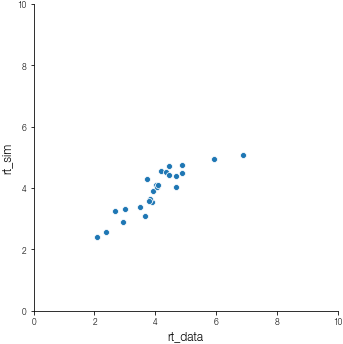

In [22]:
g = sns.relplot(
    x='rt_data', y='rt_sim',
    data=full.groupby('subj_idx')[['rt_data', 'rt_sim']].mean().reset_index()
)
g.set(xlim=(0, 10), ylim=(0, 10));

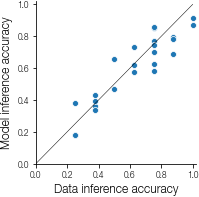

In [35]:
g = sns.relplot(
    x='response_data', y='response_sim', height=3,
    data=full.groupby('subj_idx')[['response_data', 'response_sim']].mean().reset_index()
)
g.set(xlim=(0, 1.02), ylim=(0, 1.02));
g.set_xlabels('Data inference accuracy');
g.set_ylabels('Model inference accuracy');
g.ax.plot([0, 1], [0, 1], '-k', linewidth=0.5);
g.savefig(os.path.join(res_dir, 'acc_model.pdf'))

### Plot fit to trial RT

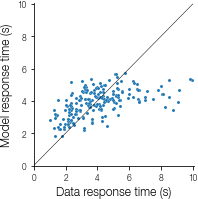

In [23]:
g = sns.relplot(
    x='rt_data', y='rt_sim', data=full, height=3, s=10, linewidth=0.2, legend=False
)
g.set(xlim=(0, 10.05), ylim=(0, 10.05));
g.set_xlabels('Data response time (s)');
g.set_ylabels('Model response time (s)');
g.ax.plot([0, 10], [0, 10], '-k', linewidth=0.5);
g.savefig(os.path.join(res_dir, 'rt_model.pdf'))